# Explainable AI - SHAP and tree based models

## Libraries (as usual)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost

import os
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## The path to the dataset

In [15]:
DATA_PATH = "/home/ruima/code/delaunan/clintrialpredict/data"
df = pd.read_csv(os.path.join(DATA_PATH, 'project_data.csv'))
df.columns
#df.shape
#df.head

Index(['nct_id', 'start_date_type', 'start_date', 'study_type',
       'overall_status', 'phase', 'number_of_arms', 'why_stopped', 'target',
       'start_year', 'phase_ordinal', 'covid_exposure', 'includes_us',
       'is_international', 'allocation', 'intervention_model',
       'primary_purpose', 'masking', 'num_primary_endpoints', 'lead_sponsor',
       'agency_class', 'sponsor_clean', 'sponsor_tier', 'gender',
       'healthy_volunteers', 'adult', 'child', 'older_adult',
       'criteria_len_log', 'best_pathology', 'therapeutic_area',
       'therapeutic_subgroup_name', 'competition_broad', 'competition_niche',
       'txt_tags', 'txt_criteria'],
      dtype='object')

## Adding the last version of SHAP

In [16]:
!pip install shap==0.49.1
import shap
# Run the following command. Needed for some visualizations.
shap.initjs();

In [18]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")

# 2. Import Custom Modules

from src.data_loader import ClinicalTrialLoader
from src.preprocessing import get_pipeline

Project Root: /home/ruima/code/delaunan/clintrialpredict
Data Path:    /home/ruima/code/delaunan/clintrialpredict/data


In [19]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/ruima/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (67363, 36)


In [20]:
# ----------------------------------------------------------------------------------
# TEMPORAL SPLIT & STATISTICS REPORT
# ----------------------------------------------------------------------------------

# 1. Sort by Date to ensure we predict the future from the past
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (e.g., 80% Train, 20% Test)
split_idx = int(len(df) * 0.80)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 3. Define Features & Target
target_col = 'target'
drop_cols = [target_col, 'overall_status', 'nct_id']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

# ----------------------------------------------------------------------------------
# PRINT STATISTICS
# ----------------------------------------------------------------------------------
def print_stats(name, dataset, y):
    n_total = len(dataset)
    n_good = len(dataset[y == 0]) # 0 = Completed
    n_bad = len(dataset[y == 1])  # 1 = Terminated/Withdrawn

    pct_good = (n_good / n_total) * 100
    pct_bad = (n_bad / n_total) * 100

    min_year = dataset['start_year'].min()
    max_year = dataset['start_year'].max()

    print(f"--- {name} SET ---")
    print(f"Time Period:   {int(min_year)} to {int(max_year)}")
    print(f"Total Trials:  {n_total}")
    print(f"Good (0):      {n_good} ({pct_good:.1f}%)")
    print(f"Bad (1):       {n_bad} ({pct_bad:.1f}%)")
    print("")

print("="*40)
print("DATASET SPLIT STATISTICS")
print("="*40)

# Overall
print_stats("OVERALL", df, df[target_col])

# Training
print_stats("TRAINING (Past)", train_df, y_train)

# Testing
print_stats("TESTING (Future)", test_df, y_test)

print("="*40)
print(f"Split Ratio: {len(train_df)/len(df):.0%} Train / {len(test_df)/len(df):.0%} Test")

DATASET SPLIT STATISTICS
--- OVERALL SET ---
Time Period:   2000 to 2015
Total Trials:  67363
Good (0):      56414 (83.7%)
Bad (1):       10949 (16.3%)

--- TRAINING (Past) SET ---
Time Period:   2000 to 2013
Total Trials:  53890
Good (0):      45421 (84.3%)
Bad (1):       8469 (15.7%)

--- TESTING (Future) SET ---
Time Period:   2013 to 2015
Total Trials:  13473
Good (0):      10993 (81.6%)
Bad (1):       2480 (18.4%)

Split Ratio: 80% Train / 20% Test


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Build Pipeline
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced', # This handles Class 0 vs Class 1 balance automatically
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Fit WITHOUT Phase Weights
print(f"Training Logistic Regression on {len(X_train)} trials...")

model.fit(X_train, y_train)

print("Training Complete.")

Training Logistic Regression on 53890 trials...
Training Complete.


--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.6927  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3274   (Baseline: 0.1841)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.37      0.53     10993
           1       0.24      0.87      0.37      2480

    accuracy                           0.46     13473
   macro avg       0.58      0.62      0.45     13473
weighted avg       0.80      0.46      0.50     13473



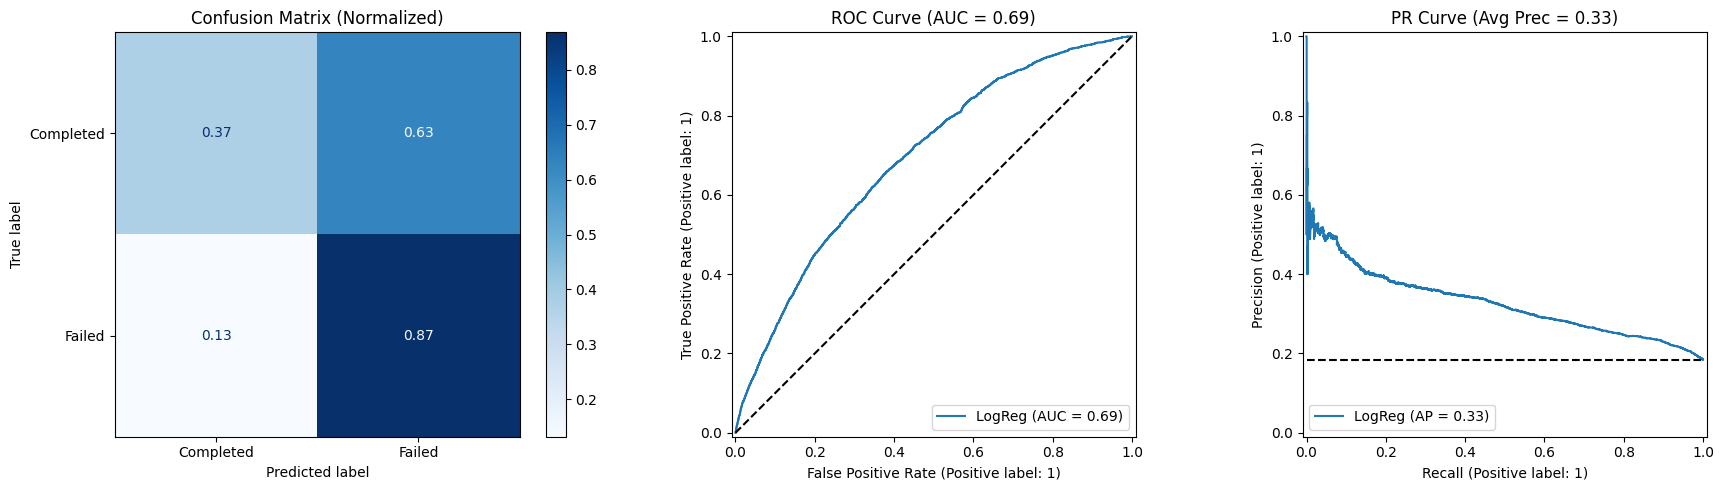

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

## Fit the model

In [ ]:


# -----------------------------
# 2. Build the SHAP explainer
# -----------------------------
explainer = shap.LinearExplainer(model.named_steps['clf'], X)
shap_values = explainer.shap_values(X)

# Plot summary
shap.summary_plot(shap_values, X)
explainer = shap.TreeExplainer(model)

# For speed, sample 2000 rows for SHAP
X_sample = X_test.sample(n=2000, random_state=0)

shap_values = explainer(X_sample)

# -----------------------------
# 3. Global SHAP: feature importance
# -----------------------------
shap.plots.bar(shap_values, max_display=30)
shap.plots.beeswarm(shap_values, max_display=30)


# Pick one trial by its row index in X
trial_idx = 42  # change as needed


x_trial = X.iloc[[trial_idx]]     # keep as DataFrame (2D)
shap_trial = explainer(x_trial)   # Explanation object with shape (1, n_features)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

In [13]:
import xgboost as xgb
print(xgb.__version__)

2.1.4


## Visualizing the SHAP values

In [ ]:
shap.plots.bar(shap_values[0])

shap.plots.waterfall(shap_values[0])

shap.plots.force(shap_values[0])